In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [185]:
#load encounters and Medications dataset
encounters=pd.read_csv('/content/drive/MyDrive/Final Project1/encounters.csv')
medications=pd.read_csv('/content/drive/MyDrive/Final Project1/medications.csv')

In [307]:
#combining loaded two datasets
combined_df=pd.merge(encounters,medications,how='inner',left_on='Id',right_on='ENCOUNTER')
# Considering cost only from the past 5 years as beyond that would be obsolete.
combined_df=combined_df[pd.to_datetime(combined_df['START_x']).dt.year>=2016]

In [422]:
combined_df.shape

(74120, 27)

In [423]:
print("Unique No of Patients: ",len(combined_df['PATIENT_x'].unique()))

Unique No of Patients:  8187


Considering Columns according to Problem Statement

In [310]:
#considering only required columns as per problem statement
inputdata=combined_df[['PATIENT_x','BASE_ENCOUNTER_COST','BASE_COST']]
inputdata['YEAR']=pd.to_datetime(combined_df['START_x']).dt.year

Group Medication and Encounter costs spent in an Year - For each Patient

In [312]:
# Summing up costs that falls in same year
inputdata=inputdata.groupby(['PATIENT_x','YEAR']).agg({'BASE_ENCOUNTER_COST':'sum',
                                             'BASE_COST':'sum'}).reset_index()

**Encounter Cost - Trend of Each Patient spent over the past 5 Years**

Text(0, 0.5, 'ENCOUNTER COST')

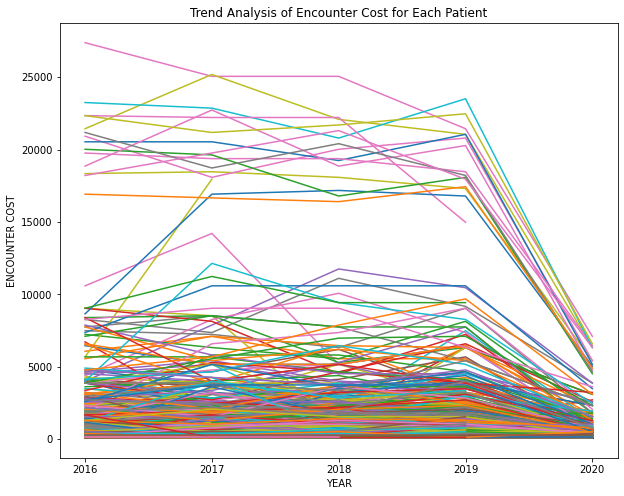

In [269]:
plt.figure(figsize=(10,8))
plt.title('Trend Analysis of Encounter Cost for Each Patient')
plt.locator_params(integer=True)
for name,group in inputdata.groupby('PATIENT_x'):
  plt.plot(group['YEAR'],group['BASE_ENCOUNTER_COST'])
plt.xlabel('YEAR')
plt.ylabel('ENCOUNTER COST')

**Medication Cost - Trend of Each Patient spent over the past 5 Years**

Text(0.5, 1.0, 'Trend Analysis of MEDICATION COST for each Patient')

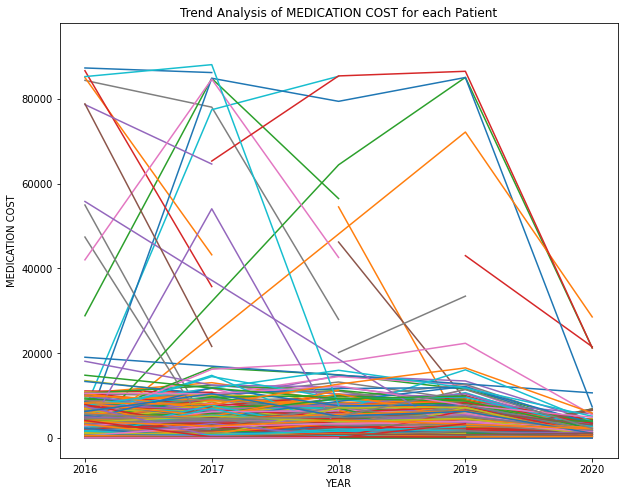

In [419]:
plt.figure(figsize=(10,8))
plt.locator_params(integer=True)
for name,group in inputdata.groupby('PATIENT_x'):
  plt.plot(group['YEAR'],group['BASE_COST'])
plt.xlabel('YEAR')
plt.ylabel('MEDICATION COST')
plt.title('Trend Analysis of MEDICATION COST for each Patient')

Out of 8000+ patients, only 59 patients who has spent more than 15000 for Encounter Cost. Considering them as Outliers, dropping Patients who spent more than 15000 for EC.

In [420]:
patient_index=inputdata[inputdata['BASE_ENCOUNTER_COST']>15000]['PATIENT_x'].index
inputdata.drop(patient_index,axis=0,inplace=True)

After removing Outliers

Text(0, 0.5, 'ENCOUNTER COST')

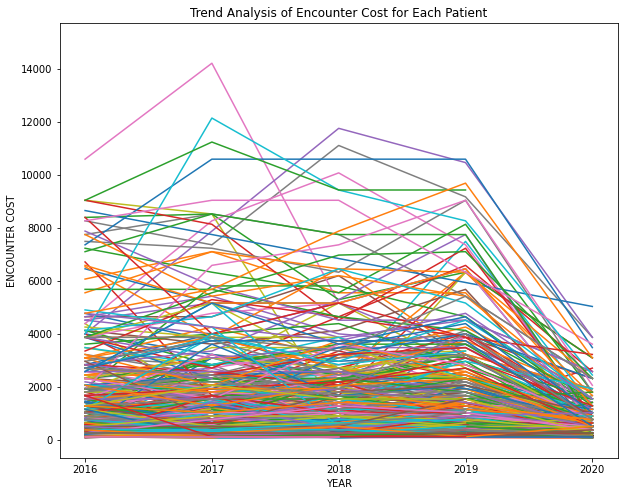

In [314]:
plt.figure(figsize=(10,8))
plt.title('Trend Analysis of Encounter Cost for Each Patient')
plt.locator_params(integer=True)
for name,group in inputdata.groupby('PATIENT_x'):
  plt.plot(group['YEAR'],group['BASE_ENCOUNTER_COST'])
plt.xlabel('YEAR')
plt.ylabel('ENCOUNTER COST')

Preparing Data to represent in the below format<br>

Patient | Year | Medication Cost | Medication Cost_1_Year_ago | Medication Cost_2_Year_ago | Medication Cost_3_Year_ago
--- | --- | --- | --- | --- | --- |
P1 | 2020 | 200 | 190 | 185 | 175 
P2 | 2019 | 500 | 290 | 305 | 275 

In [317]:
#last encounter of each patient
working_df=inputdata.groupby('PATIENT_x').nth(-1)
# 2nd Encounter from last for each patient
previous_encounter=inputdata.groupby('PATIENT_x').nth(-2)
previous_encounter.rename(columns={'BASE_ENCOUNTER_COST':'Encounter_cost_1_year_ago','BASE_COST':'Medication_cost_1_year_ago','YEAR':'1stPyear'},inplace=True)
# combining last 2 encounters
combined=pd.merge(working_df,previous_encounter,how='outer',left_on='PATIENT_x',right_on='PATIENT_x')

In [318]:
# 3rd encounter from last
previous_encounter=inputdata.groupby('PATIENT_x').nth(-3)
previous_encounter.rename(columns={'BASE_ENCOUNTER_COST':'Encounter_cost_2_year_ago','BASE_COST':'Medication_cost_2_year_ago','YEAR':'2ndPyear'},inplace=True)
# combining last 3 encounters
combined1=pd.merge(combined,previous_encounter,how='outer',left_on='PATIENT_x',right_on='PATIENT_x')

In [319]:
# 4th Encounter from last
previous_encounter=inputdata.groupby('PATIENT_x').nth(-4)
previous_encounter.rename(columns={'BASE_ENCOUNTER_COST':'Encounter_cost_3_year_ago','BASE_COST':'Medication_cost_3_year_ago','YEAR':'3rdPyear'},inplace=True)
# combining last 4 encounters
finalmerge=pd.merge(combined1,previous_encounter,how='outer',left_on='PATIENT_x',right_on='PATIENT_x')

In [434]:
finalmerge.shape
finalmerge.to_csv('/content/drive/MyDrive/Final Project1/Data Process/Medical_Cost_InputData.csv')

In [321]:
finalmerge.isnull().sum()

YEAR                             0
BASE_ENCOUNTER_COST              0
BASE_COST                        0
1stPyear                      2171
Encounter_cost_1_year_ago     2171
Medication_cost_1_year_ago    2171
2ndPyear                      3481
Encounter_cost_2_year_ago     3481
Medication_cost_2_year_ago    3481
3rdPyear                      4235
Encounter_cost_3_year_ago     4235
Medication_cost_3_year_ago    4235
dtype: int64

In [389]:
#taking copy of finalmerge dataset to work
in_df=finalmerge.copy()
in_df.drop(['1stPyear','2ndPyear','3rdPyear'],axis=1,inplace=True)

In [243]:
in_df.head()

,YEAR,BASE_ENCOUNTER_COST,BASE_COST,1stPyear,Encounter_cost_1_year_ago,Medication_cost_1_year_ago,2ndPyear,Encounter_cost_2_year_ago,Medication_cost_2_year_ago,3rdPyear,Encounter_cost_3_year_ago,Medication_cost_3_year_ago
PATIENT_x,,,,,,,,,,,,
0002edb7-9477-4bc9-a2b7-d5137e7e9ed4,2019,258.32,271.08,2018.0,129.16,263.49,2017.0,129.16,263.49,2016.0,129.16,263.49
0007fa20-c7b2-4764-b4f1-c3e96b241082,2019,129.16,37.80,2018.0,387.48,1658.83,2017.0,129.16,38.05,2016.0,129.16,89.59
000f6134-cefd-41f8-8bc7-144221c7e07e,2019,129.16,263.49,2018.0,129.16,263.49,2017.0,129.16,263.49,2016.0,258.32,268.82
000ffb8b-d295-44a7-9d88-45d39ea9d2ba,2020,2324.88,3054.77,2019.0,3874.80,4079.54,2018.0,1808.24,2699.30,2017.0,3229.00,5802.07
0012398d-381b-44f4-879f-a5dc81bdf7be,2018,129.16,30.60,2017.0,129.16,263.49,NaN,NaN,NaN,NaN,NaN,NaN


Distribution of Encounter Cost for past 4 Years

---


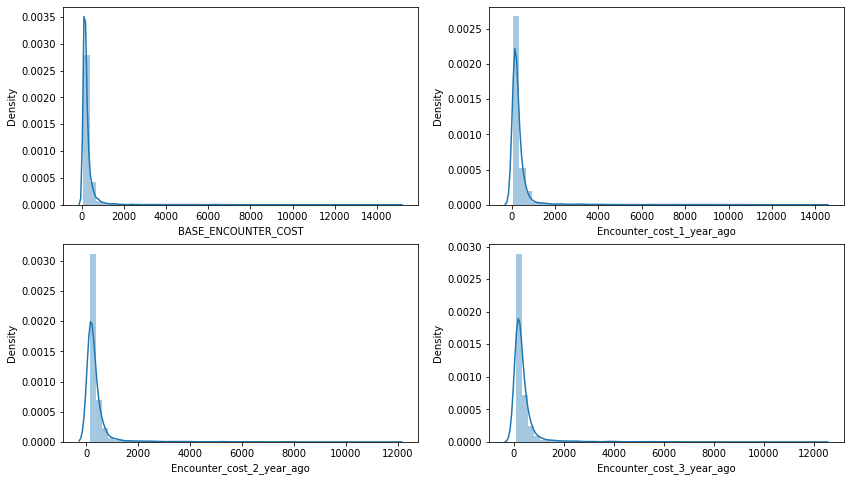

In [296]:
a,axes=plt.subplots(2,2,figsize=(14,8))
sns.distplot(in_df['BASE_ENCOUNTER_COST'],ax=axes.flatten()[0])
sns.distplot(in_df['Encounter_cost_1_year_ago'],ax=axes.flatten()[1])
sns.distplot(in_df['Encounter_cost_2_year_ago'],ax=axes.flatten()[2])
sns.distplot(in_df['Encounter_cost_3_year_ago'],ax=axes.flatten()[3])

Distribution of Medication Cost for past 4 Years

---

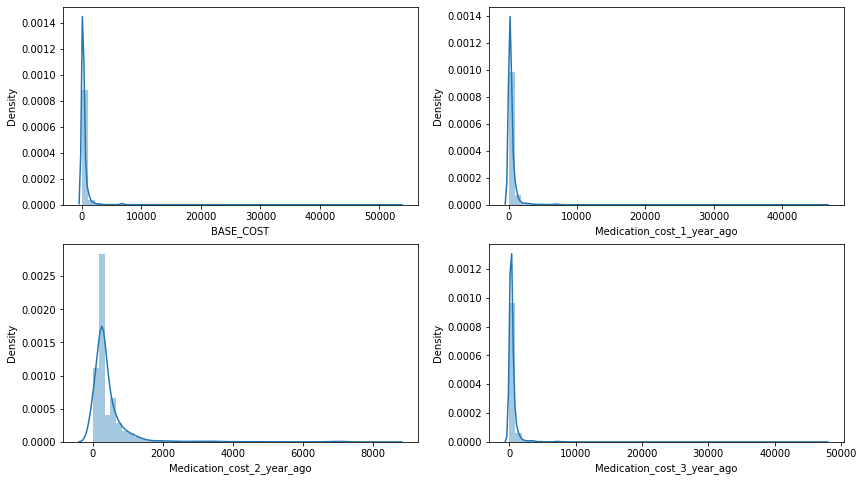

In [338]:
a,axes=plt.subplots(2,2,figsize=(14,8))
sns.distplot(in_df['BASE_COST'],ax=axes.flatten()[0])
sns.distplot(in_df['Medication_cost_1_year_ago'],ax=axes.flatten()[1])
sns.distplot(in_df['Medication_cost_2_year_ago'],ax=axes.flatten()[2])
sns.distplot(in_df['Medication_cost_3_year_ago'],ax=axes.flatten()[3])

**Imputation - For each Patient impute based on her/his own Previous Medical record**

In [386]:
def impute_columns(col1,col2,col3,col4):
  for index,row in in_df.iterrows():
    if pd.isna(row[col2]):
      in_df.loc[index,col2]=row[col1]
    if pd.isna(row[col3]):
      in_df.loc[index, col3]=in_df.loc[index,col2]
    if pd.isna(row[col4]):
      in_df.loc[index,col4]=in_df.loc[index,col3]

In [387]:
impute_columns('BASE_ENCOUNTER_COST','Encounter_cost_1_year_ago','Encounter_cost_2_year_ago','Encounter_cost_3_year_ago')
impute_columns('BASE_COST','Medication_cost_1_year_ago','Medication_cost_2_year_ago','Medication_cost_3_year_ago')

In [404]:
in_df.isnull().sum()

YEAR                          0
BASE_ENCOUNTER_COST           0
BASE_COST                     0
Encounter_cost_1_year_ago     0
Medication_cost_1_year_ago    0
Encounter_cost_2_year_ago     0
Medication_cost_2_year_ago    0
Encounter_cost_3_year_ago     0
Medication_cost_3_year_ago    0
dtype: int64

**Removing Outliers based on Z-Score**

In [400]:
def find_drop_outliers(col):
  threshold=3
  outlier = []
  std_dev=in_df[col].std()
  mean=in_df[col].mean()
  for i in in_df[col]:
    z=(i-mean)/std_dev
    if z>threshold:
      outlier.append(i)
  outlier_index=in_df[in_df[col].isin(outlier)].index
  in_df.drop(outlier_index,axis=0,inplace=True)

In [401]:
find_drop_outliers('BASE_ENCOUNTER_COST')
find_drop_outliers('Encounter_cost_1_year_ago')
find_drop_outliers('Encounter_cost_2_year_ago')
find_drop_outliers('Encounter_cost_3_year_ago')

In [402]:
find_drop_outliers('BASE_COST')
find_drop_outliers('Medication_cost_1_year_ago')
find_drop_outliers('Medication_cost_2_year_ago')
find_drop_outliers('Medication_cost_3_year_ago')

In [430]:
print("No of Patients after removing Outliers",in_df.shape[0])

No of Patients after removing Outliers 7293


Around 10% of patients are removed considering as Outliers.

In [405]:
X=in_df[['Encounter_cost_1_year_ago','Encounter_cost_2_year_ago','Encounter_cost_3_year_ago','Medication_cost_1_year_ago','Medication_cost_2_year_ago','Medication_cost_3_year_ago']]
y=in_df[['BASE_ENCOUNTER_COST','BASE_COST']]

**Split Train and Test**

In [406]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [407]:
X_train1=X_train[['Medication_cost_1_year_ago','Medication_cost_2_year_ago','Medication_cost_3_year_ago']]
X_test1=X_test[['Medication_cost_1_year_ago','Medication_cost_2_year_ago','Medication_cost_3_year_ago']]
y_train1=y_train[['BASE_COST']]
y_test1=y_test[['BASE_COST']]

X_train=X_train[['Encounter_cost_1_year_ago','Encounter_cost_2_year_ago','Encounter_cost_3_year_ago']]
X_test=X_test[['Encounter_cost_1_year_ago','Encounter_cost_2_year_ago','Encounter_cost_3_year_ago']]
y_train=y_train[['BASE_ENCOUNTER_COST']]
y_test=y_test[['BASE_ENCOUNTER_COST']]

# **Prediction of Encounter Cost**

**Train Model and Predict**

In [408]:
lr=LinearRegression()
rf=RandomForestRegressor(n_estimators=100)

lr.fit(X_train,y_train)
linear_prediction=lr.predict(X_test)

rf.fit(X_train,y_train)
rf_prediction=rf.predict(X_test)

In [409]:
lr1=LinearRegression()
rf1=RandomForestRegressor(n_estimators=100)

lr1.fit(X_train1,y_train1)
linear_prediction_MC=lr1.predict(X_test1)

rf1.fit(X_train1,y_train1)
rf_prediction_MC=rf1.predict(X_test1)

**Measuring Performance of Models**

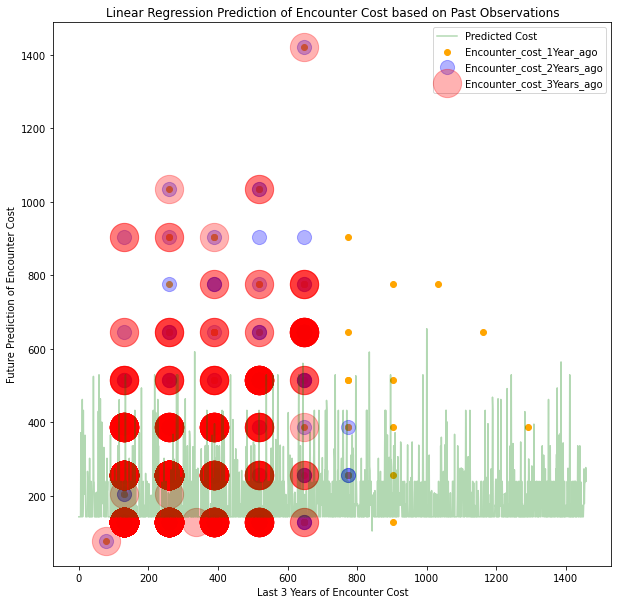

In [410]:
plt.figure(figsize=(10,10))
plt.scatter(X_test.iloc[:,0],y_test,color='orange',label='Encounter_cost_1Year_ago')
plt.scatter(X_test.iloc[:,1],y_test,color='blue',s=200,alpha=0.3,label='Encounter_cost_2Years_ago')
plt.scatter(X_test.iloc[:,2],y_test,color='red',s=800,alpha=0.3,label='Encounter_cost_3Years_ago')

plt.plot(linear_prediction,color='green',alpha=0.3,label='Predicted Cost')
plt.xlabel('Last 3 Years of Encounter Cost')
plt.ylabel('Future Prediction of Encounter Cost')
plt.title('Linear Regression Prediction of Encounter Cost based on Past Observations')
plt.legend()
plt.show()

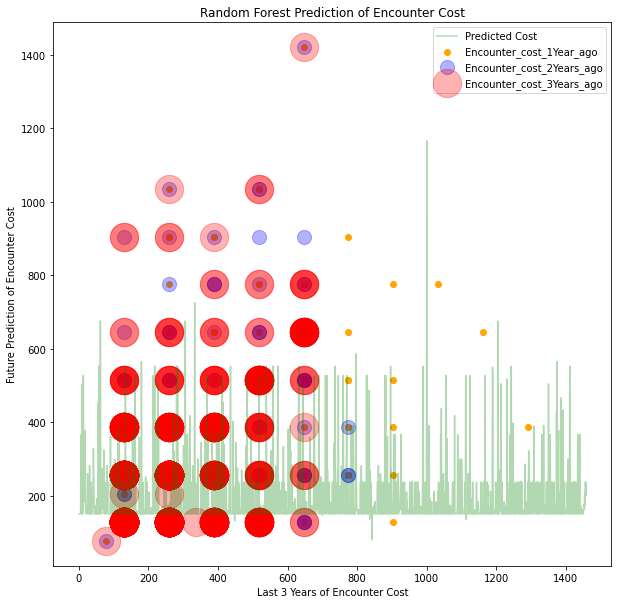

In [411]:
plt.figure(figsize=(10,10))
plt.scatter(X_test.iloc[:,0],y_test,color='orange',label='Encounter_cost_1Year_ago')
plt.scatter(X_test.iloc[:,1],y_test,color='blue',s=200,alpha=0.3,label='Encounter_cost_2Years_ago')
plt.scatter(X_test.iloc[:,2],y_test,color='red',s=800,alpha=0.3,label='Encounter_cost_3Years_ago')

plt.plot(rf_prediction,color='green',alpha=0.3,label='Predicted Cost')
plt.xlabel('Last 3 Years of Encounter Cost')
plt.ylabel('Future Prediction of Encounter Cost')
plt.title('Random Forest Prediction of Encounter Cost')
plt.legend()
plt.show()

In [412]:
rmse_rf=sqrt(mean_squared_error(rf_prediction,y_test))
rmse_lr=sqrt(mean_squared_error(linear_prediction,y_test))
print('Mean Squared Error for Encounter Cost using Random Forest Model is:',rmse_rf)
print('Mean Squared Error for Encounter Cost using Linear Regression Model is:',rmse_lr)

Mean Squared Error for Encounter Cost using Random Forest Model is: 102.95745835555144
Mean Squared Error for Encounter Cost using Linear Regression Model is: 102.0537770155943


In [413]:
rmse_rf=sqrt(mean_squared_error(rf_prediction_MC,y_test))
rmse_lr=sqrt(mean_squared_error(linear_prediction_MC,y_test))
print('Mean Squared Error for Medication Cost using Random Forest Model is:',rmse_rf)
print('Mean Squared Error for Medication Cost using Linear Regression Model is:',rmse_lr)

Mean Squared Error for Medication Cost using Random Forest Model is: 212.3325994107639
Mean Squared Error for Medication Cost using Linear Regression Model is: 170.28367729682077


In [418]:
Output_df=y_test.reset_index()
Output_df['Predicted Encounter Cost']=linear_prediction
Output_df['Actual Medication Cost']=y_test1.reset_index()['BASE_COST']
Output_df['Predicted Medication Cost']=linear_prediction_MC
Output_df.to_csv('Predicted_Encounter_Medication_Cost.csv',index=False)
Output_df.head()

,PATIENT_x,BASE_ENCOUNTER_COST,Predicted Encounter Cost,Actual Medication Cost,Predicted Medication Cost
0,c5a8c98e-991c-473b-bb18-cd73a3e25317,129.16,143.456902,8.62,91.722704
1,3c201d2e-47c7-49d1-9fb6-0acf914ff4d0,129.16,143.456902,263.49,253.614286
2,65f28e6d-25d5-46bb-aac2-a0eb9f0fec69,129.16,143.456902,557.97,317.612483
3,43812082-e689-4bb5-b91b-85484ec27d83,129.16,143.456902,33.76,541.039014
4,85069397-9800-4c9c-9fb5-3fa6f5d8c4e2,129.16,143.456902,34.91,108.421922


**CONCLUSION:**
Linear Regression and Random Forest Regressor algorithm predicted the future Encounter cost for next 12 months. Linear Regression Algorithm is slightly performed better than Random Forest Regressor